# Lab 4 Regression




Minería de Datos  
Catedrático Luis Valdeavellano  
Auxiliares Kristen Brandt y María Fernanda López  
Pablo Ruiz 18259  

---

Insurance.csv debe ser subido de la siguiente manera (si se corre en Drive) y puede ser descargado de [Kaggle insurance.csv](https://www.kaggle.com/sonujha090/insurance-prediction):

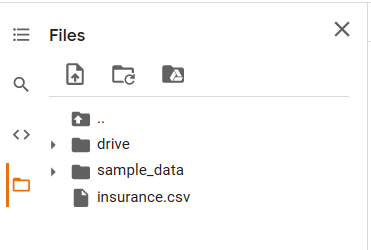






## Resumen
En este *notebook* se detallan los resultados obtenidos al aplicar regresiones lineales y polinomiales e intentar predecir los cargos del seguro sobre un conjunto de datos que incluye estos cargos según diversos factores. Se encontró que la regresión más adecuada fue la polinomial con varias variables.


In [28]:
# Módulos requeridos
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install sklearn
!pip install pingouin
!pip install sympy

In [29]:
# Importando los módulos
import pandas as pd
import seaborn as sbrn
import numpy as np
import pingouin as pg
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sympy import *


## Hipótesis
La hipótesis de este laboratorio fue que las regresiones polinomiales tendrían mejores predicciones de los cargos que las lineales y que los modelos con varias variables independientes serían más certeros.


## Objetivos
* Programar un modelo de regresión lineal sin módulos dedicados a esto. 
* Utilizar la regresión lineal y polinomial para predecir elementos del conjunto de datos.

## Exploración de los datos

### Información del conjunto de datos
Los datos muestran los cargos de seguro realizados a distintas personas según su
edad, sexo, ínidice de masa corporal, si es fumador o no y la región en donde se
localizan.

#### Se exploraron los siguientes elementos:
* Estructura de los campos
* Información de los campos y tipos de datos
* Exploración de estadísticas generales de los campos
* Pairwise de los campos numéricos
* Histogramas de los campos no numéricos

A continuación se muestra la exploración de los datos a detalle:


In [3]:
data = pd.read_csv('./insurance.csv')

In [4]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


In [5]:
data.dtypes

age           int64
sex           int64
bmi         float64
children      int64
smoker        int64
region        int64
charges     float64
dtype: object

In [6]:
data.describe()

,age,sex,bmi,children,smoker,region,charges
count,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,39.591954,0.508621,30.676552,1.091954,0.232759,1.497126,14016.426293
std,14.417015,0.500646,5.625850,1.192021,0.423198,1.104089,12638.887852
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,1137.011000
25%,27.000000,0.000000,26.782500,0.000000,0.000000,1.000000,4888.466125
50%,40.000000,1.000000,30.300000,1.000000,0.000000,2.000000,9719.305250
75%,53.000000,1.000000,34.777500,2.000000,0.000000,2.000000,19006.316150
max,64.000000,1.000000,49.060000,5.000000,1.000000,3.000000,51194.559140


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       348 non-null    int64  
 1   sex       348 non-null    int64  
 2   bmi       348 non-null    float64
 3   children  348 non-null    int64  
 4   smoker    348 non-null    int64  
 5   region    348 non-null    int64  
 6   charges   348 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 19.2 KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b7f0c3510>]],
      dtype=object)

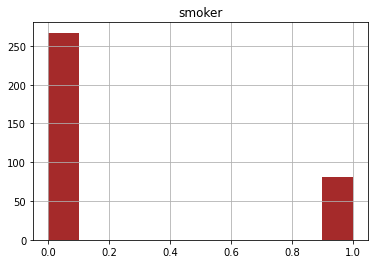

In [8]:
data.hist("smoker", color="brown")

Hay más no fumadores que fumadores.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b7f030c10>]],
      dtype=object)

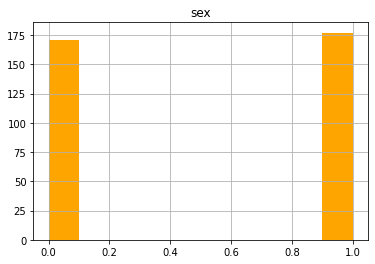

In [9]:
data.hist("sex", color="orange")

La cantidad de personas por sexo es muy cercana.

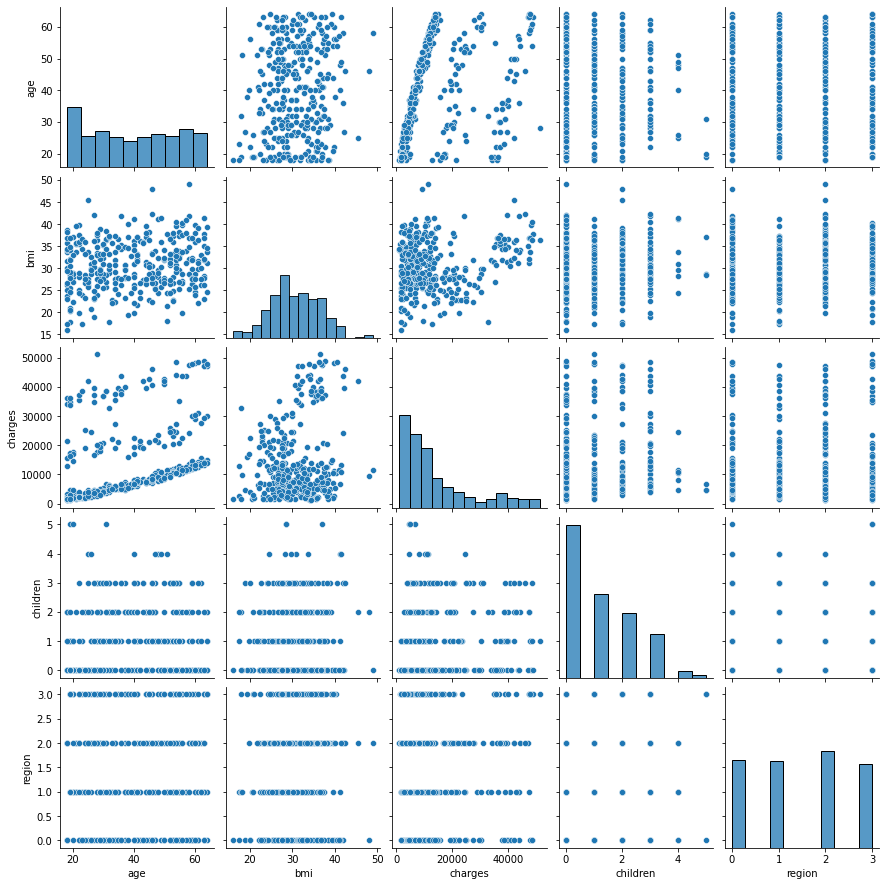

In [10]:
pairplot_data = data[["age", "bmi", "charges", "children", "region"]]
sbrn.pairplot(data=pairplot_data)

Los cargos se concentran en montos más bajos, pero suben conforme la edad avanza. 

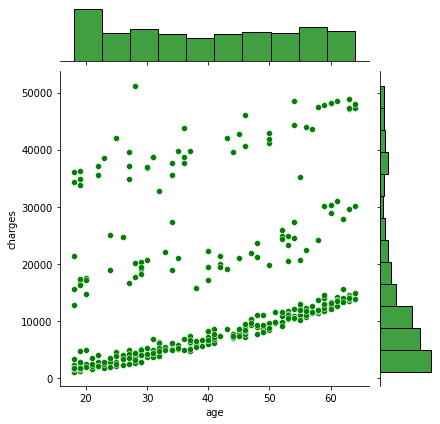

In [11]:
sbrn.jointplot(data=data, x="age", y="charges", color="green")

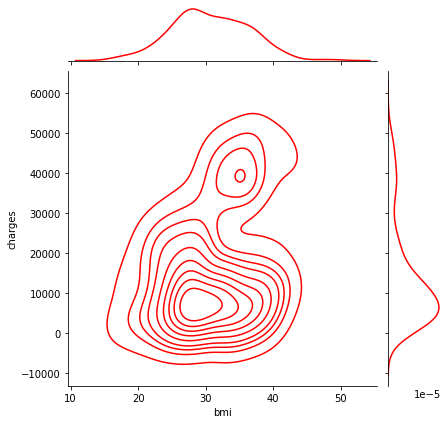

In [12]:
sbrn.jointplot(data=data, x="bmi", y="charges", color="red", kind="kde")

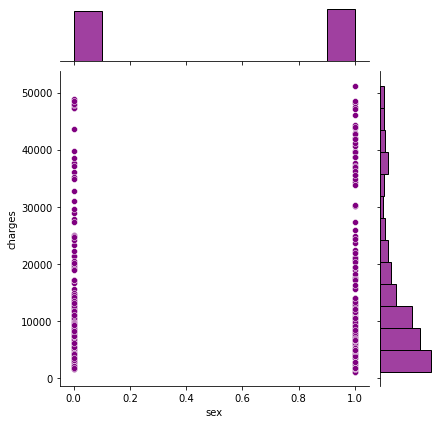

In [13]:
sbrn.jointplot(data=data, x="sex", y="charges", color="purple")

Los hombres presentan una concentración de cargos mayor en los montos superiores a 35 000. 

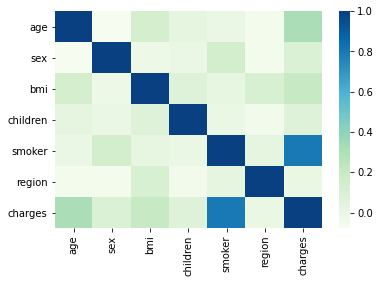

In [14]:
sbrn.heatmap(data.corr(),cmap='GnBu')

Hay una alta correlación entre ser fumador y los cargos del seguro. También hay correlación con la edad y más levemente con el sexo, índice de masa corporal, hijos y región. 

## Preparación de los datos

### Datos faltantes
Debido a que no hay datos nulos, no fue requerido reemplazar campos.   
La validación se muestra a continuación:

In [15]:
f"No hay nulos: {0 == data.isnull().sum().sum()}"

'No hay nulos: True'

### Preparación de datos categóricos
Se codificaron los campos de **sex** y **smoker** con un *Label Encoder* y el campo de **region** con un *On Hot Encoder*. 

In [16]:
label_encoder = LabelEncoder()
hot_encoder = OneHotEncoder()
data['sex'] = label_encoder.fit_transform(data['sex'])
data['smoker'] = label_encoder.fit_transform(data['smoker'])
# region_data = pd.DataFrame(hot_encoder.fit_transform(data[['region']]).toarray())
data['region'] = data['region'].astype('category')
data = pd.get_dummies(data)

data

,age,sex,bmi,children,smoker,charges,region_0,region_1,region_2,region_3
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
343,63,1,36.765,0,0,13981.85035,1,0,0,0
344,49,0,41.470,4,0,10977.20630,0,0,1,0
345,34,0,29.260,3,0,6184.29940,0,0,1,0
346,33,1,35.750,2,0,4889.99950,0,0,1,0


## División de los datos en training y test.
Se busca predecir el campo **charges**.   
Debido a que el dataset no es muy grande (348 filas), se reservó el 15% para el test.

In [17]:
x_0 = data[['bmi']]
x = data[['age', 'sex', 'bmi', 'children', 'smoker', 'region_0', 'region_1', 'region_2', 'region_3']]
y = data['charges']

x0_train, x0_test, y0_train, y0_test = train_test_split(x_0, y, test_size=0.15)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15)

## Escala de los datos
Se utilizó un *standard scaler* para colocar la media en 0 y una desviación estándar de 1 en las variables independientes (todas menos **charges**).

In [18]:
scaler = StandardScaler() 

In [19]:
def calculate_metrics(y_test, y_pred):

  print(f"""
  Mean absolute error: {mean_absolute_error(y_test, y_pred)}
  Mean squared error: {mean_squared_error(y_test, y_pred)}
  Root mean squared error: {mean_squared_error(y_test, y_pred, squared=False)}
  R^2: {r2_score(y_test, y_pred)}
  """)

## Regresión lineal con una variable
Se realizaron regresiones lineales con la variable **bmi**. La primera fue elaborada sin librerías externas de regresión lineal y la segunda fue elaborada mediante *Scikit-learn*. El valor p de **bmi** se muestra a continuación. Debido a que es pequeño, indica que es estadísticamente significativo. No obstante, al no tener otras variables con las cuales comparar, no es muy relevante.  

### Resultados de la regresión
Se pudo observar que tanto el modelo realizado sin librerías de regresión lineal como el modelo con librerías llegaron al mismo resultado, por lo que se concluye que el modelo programado fue correcto. No obstante, al utilizar solamente la variable **bmi**, la regresión obtenida no fue muy buena debido a que el error medio cuadrático (MSE),  la raíz del error medio cuadrático (RMSE)y el error medio cuadrático fueron elevados. Además, el coeficiente R^2 fue bajo (0.02686). Estos datos se pueden observar sobre las gráficas de las regresiones. 


In [20]:
lm = pg.linear_regression(x0_train, y0_train)
print(lm[['names', 'pval']])

       names      pval
0  Intercept  0.834134
1        bmi  0.000166


### Regresión elaborada sin librerías de regresión lineal

2720.75148989786 14127.5363225085

  Mean absolute error: 10670.820183680122
  Mean squared error: 170088439.63907573
  Root mean squared error: 13041.79587476647
  R^2: 0.02686448521200968
  


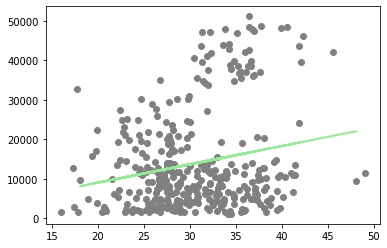

In [21]:
x_symbol = symbols('x')
y_symbol = symbols('y')
def quadratic_least_square_regression(points):
    """
    Calculates the quadratic least square regression of a set of points
    :param points: points
    :return: a0 and a1 values of the regression
    """
    n = len(points)
    x_summation = ls_summation(points, "x")
    y_summation = ls_summation(points, "y")
    xy_summation = ls_summation(points, "x * y")
    x_squared_summation = ls_summation(points, "x ** 2")

    intercept = (x_squared_summation * y_summation - x_summation * xy_summation) / (n * x_squared_summation - x_summation ** 2)
    slope = (n * xy_summation - x_summation * y_summation) / (n * x_squared_summation - x_summation ** 2)

    return slope, intercept

def ls_summation(points, function):
    """
    Calculates the least square regression needed summations
    :param points: point list
    :param function: function for the summation
    :return: summation result
    """
    ls_result = 0
    function = parse_expr(function)

    for i in range(0, len(points)):
        ls_result += function.evalf(subs={x_symbol: points[i][0], y_symbol: points[i][1]})
    return ls_result


def predict_values(intercept, slope, test_points):
  y_values = []
  for point in test_points:
    y_values.append(slope * point + intercept)
  return y_values


def list_points(point_list):
  returning_list = []
  for point in point_list:
    returning_list.append(point[0])
  return returning_list


slope, intercept = quadratic_least_square_regression([list(a) for a in zip(list_points(scaler.fit_transform(x0_train)), y0_train)])
print(slope, intercept)
y_pred = predict_values(intercept, slope, list_points(scaler.fit_transform(x0_test)))



calculate_metrics(y0_test, y_pred)
plt.scatter(x_0, y, color='gray')
plt.plot(x0_test, y_pred, color='lightgreen', linewidth=2)
plt.show()

### Regresión elaborada con *Scikit-learn*


  Mean absolute error: 10670.820183680129
  Mean squared error: 170088439.63907576
  Root mean squared error: 13041.795874766472
  R^2: 0.02686448521200946
  


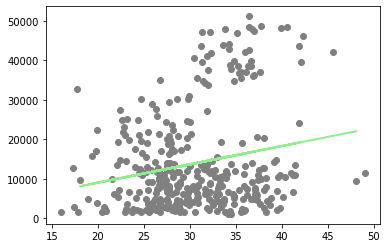

In [22]:
regression = LinearRegression(normalize=False)

regression.fit(scaler.fit_transform(x0_train), y0_train)
y_pred = regression.predict(scaler.fit_transform(x0_test))
calculate_metrics(y0_test, y_pred)
plt.scatter(x_0, y, color='gray')
plt.plot(x0_test, y_pred, color='lightgreen', linewidth=2)
plt.show()

### Regresión lineal con varias variables
En este caso se encontraron los valores p para las distintas variables. Se encontró que las variables eran relevantes debido a que sus valores p fueron cercanos a 0. Las variables más relevantes fueron: **smoker**, **age** y **bmi**.

Esta regresión fue mucho más efectiva que las anteriores que solamente consideraron **bmi**. Esto se refleja en que tuvo un MAS, MSE y RMSE significativamente más bajo a los modelos anteriores. Además, el valor de R^2 fue mucho más elevado (0.77855).




In [23]:
regression.fit(scaler.fit_transform(x_train), y_train)
y_pred = regression.predict(scaler.fit_transform(x_test))
calculate_metrics(y_test, y_pred)


  Mean absolute error: 3862.5355695052763
  Mean squared error: 26110099.409270972
  Root mean squared error: 5109.804243732921
  R^2: 0.7785554684301474
  


In [24]:
lm = pg.linear_regression(x_train, y_train)
print(lm[['names', 'pval']])

       names          pval
0  Intercept  2.509759e-08
1        age  6.743234e-22
2        sex  9.871530e-01
3        bmi  1.812648e-06
4   children  4.892867e-02
5     smoker  5.981471e-83
6   region_0  1.812187e-02
7   region_1  3.662063e-03
8   region_2  2.218523e-06
9   region_3  3.410294e-03


/usr/local/lib/python3.7/dist-packages/pingouin/regression.py:410: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 9 with 10 columns). That means that one or more of the columns in `X` are a linear combination of one of more of the other columns.
  warnings.warn('Design matrix supplied with `X` parameter is rank '


## Regresión polinomial
En el caso de la regresión polinomial con **bmi**, se observó que fue muy cercana a la regresión lineal, pero tuvo un error MAS más pequeño. Por otro lado, se observó en la regresión polinomial con varias variables que todos los errores fueron más bajos al compararse con la regresión lineal con varias variables. Debido a esto, se concluye que la regresión polinomial con varias variables fue la más efectiva.

In [25]:
poly = PolynomialFeatures(degree=2)


  Mean absolute error: 10586.971271692868
  Mean squared error: 170558488.86790606
  Root mean squared error: 13059.804319663677
  R^2: 0.024175168999548968
  


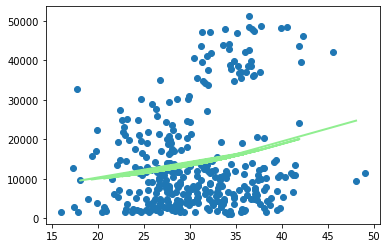

In [26]:
regression.fit(scaler.fit_transform(poly.fit_transform(x0_train)), y0_train)
y_pred = regression.predict(scaler.fit_transform(poly.fit_transform(x0_test)))
calculate_metrics(y0_test, y_pred)

plt.scatter(x_0, y)
plt.plot(x0_test, y_pred, color='lightgreen', linewidth=2)
plt.show()


In [27]:
regression.fit(scaler.fit_transform(poly.fit_transform(x_train)), y_train)
y_pred = regression.predict(scaler.fit_transform(poly.fit_transform(x_test)))
calculate_metrics(y_test, y_pred)


  Mean absolute error: 3005.148904596521
  Mean squared error: 19552093.590252154
  Root mean squared error: 4421.774936634853
  R^2: 0.8341751159796065
  


## Conclusiones
* El modelo con mejores resultados fue el de regresión polinomial con varias variables. 
* No hubo mucha diferencia entre la regresión lineal y la polinomial con una variable. 
* Los modelos con más variables fueron mejores en la predicción de los cargos del seguro que los modelos que solo utilizaron bmi. 